In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter, ResampleFilter, MorletWaveletFilter
import sys
import os
import matplotlib.pyplot as plt
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels, ENTPHC_labels
from SWRmodule import *

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [2]:
df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'catFR1' #'FR1'
save_path = '/scratch/efeghhi/FR1_data'
### params that clusterRun used
selected_period = 'encoding' # surrounding_recall # whole_retrieval # encoding 
recall_type_switch = 0 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
selected_region = HPC_labels 
region_name = 'HPC'
remove_soz_ictal = 0
recall_minimum = 2000
filter_type = 'hamming'
extra = '' #'-ZERO_IRI'

In [3]:

subs = ['R1488T','R1381T','R1004D']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
sub_df = sub_df.reset_index()
sub_df = sub_df.filter(items = [0,1,4] , axis=0)
sub_df

# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3)) & # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
                    ((df.subject!='R1311T') | (df.session!=0)) & ## these next 3 eegoffset -1 for many recalls so messes things up for clustering analysis ##
                    ((df.subject!='R1113T') | (df.session!=0)) &
                    ((df.subject!='R1137E') | (df.session!=0)) 
                   ] 
if exp == 'catFR1':
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
                    ]

# Want to try and find those files that haven't been made yet (due to memory limits) and re-run only those
# **only an issue with encoding or whole_retrieval due to their large EEG matrices**

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [4]:
# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

rerun_mask = []

for i,row in enumerate(exp_df.itertuples()):
    sub = row.subject; session = row.session; exp = row.experiment
    path_name = os.path.join(save_path, subfolder)
    fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+extra+'.p')  
    try:
        with open(fn,'rb') as f:
            dat = pickle.load(f)
    except:
        rerun_mask.append(i)
        
rerun_df = exp_df.iloc[rerun_mask]
rerun_df.head()

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
6,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
7,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
15,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
16,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
23,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...


In [18]:

def ClusterRunSWRs(param):

    import pandas as pd
    import numpy as np
    import os
    import dill, pickle
    import mne
    from copy import copy    
    from scipy.signal import firwin,filtfilt,kaiserord
    from ptsa.data.filters import ButterworthFilter, ResampleFilter, MorletWaveletFilter
    import xarray as xarray
    from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels, ENTPHC_labels, AMY_labels
    from SWRmodule import CMLReadDFRow,get_bp_tal_struct,get_elec_regions,ptsa_to_mne,detectRipplesHamming
    from general import superVstack,findInd,findAinB
    from SWRmodule import downsampleBinary,LogDFExceptionLine,getBadChannels,getStartEndArrays,getSecondRecalls,\
                        removeRepeatedRecalls,getSWRpathInfo,selectRecallType,correctEEGoffset,\
                        getSerialposOfRecalls,getElectrodeRanges,\
                        detectRipplesHamming,detectRipplesButter,getRetrievalStartAlignmentCorrection,\
                        removeRepeatsBySerialpos,get_recall_clustering, compute_morlet # specific to clustering
    
    import pingouin as pg
    
    exp = 'catFR1' # 'catFR1' #'FR1'
    save_path = f'/scratch/efeghhi/{exp}/'
    ### params that clusterRun used
    selected_period = 'encoding' # surrounding_recall # whole_retrieval # encoding 
    recall_type_switch = 0 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
    selected_region = HPC_labels 
    region_name = 'HPC'
    remove_soz_ictal = 0
    filter_type = 'hamming'
    extra = '' #'-ZERO_IRI'
    
    ### PARAMS ###
    
    ##
    ## NOTE: for looking at individual lags make sure min_recalls is set to 0 or will eliminate trials from low recall lists
    ##
    
    save_values = 1
    
    selected_period = 'encoding' # surrounding_recall # whole_retrieval # encoding 
    # there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
    recall_type_switch = 0  # switch to determine which recalls to look at! (see details below)
    # (as of 2021 always leave this as 0, since I select for 4/6/etc below)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolated recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
    

    remove_soz_ictal = 0 # 0 for nothing, 1 for SOZ, 2 for SOZ+ictal
    
    min_ripple_rate = 0.1 # Hz.
    max_ripple_rate = 1.5 # Hz.
    max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them
    max_electrode_by_electrode_correlation = 0.2

    ### semantic/temporal clustering parameters ###
    min_recalls = 0
    PCA_ndim = 1 # number of PC dims to use for semantic clustering (Ethan usually found only 1 worked for theta/FC)
    
#     # for parametric run through recall_minimums
#         recall_mins = np.arange(800,5100,100) #[800,900,1100,1200,1300,1400]
# #     recall_mins = [1600,1700,1800,1900,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
#     for recall_minimum in recall_mins:
    
    # recall params
    recall_minimum = 2000 # for isolated recalls what is minimum time for recall to be considered isolated?
    IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
    retrieval_whole_time = 10000
    # encoding params
    encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
    pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
    # these aren't likely to be changed:
    desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
    eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**
    filter_type = 'hamming' # see local version below for details. 'butter' is removed from cluster version so don't change this    
    
    ### END PARAMS ###    
        
    # get region label
    if selected_region == HPC_labels:
        region_name = 'HPC'
    elif selected_region == ENT_labels:
        region_name = 'ENT'
    elif selected_region == PHC_labels:
        region_name = 'PHC'
    elif selected_region == temporal_lobe_labels:
        region_name = 'TEMPORALLOBE'
    elif selected_region == MFG_labels:
        region_name = 'MFG'
    elif selected_region == IFG_labels:
        region_name = 'IFG'
    elif selected_region == nonHPC_MTL_labels:
        region_name = 'nonHPC_MTL'
    elif selected_region == ENTPHC_labels:
        region_name = 'ENTPHC'
    elif selected_region == AMY_labels:
        region_name = 'AMY'

    if selected_period == 'surrounding_recall':
        if IRI == 0:
            psth_start = -2000
            psth_end = 2000
        else:
            psth_start = -IRI # only makes sense to look at period <= IRI
            psth_end = IRI # how long to grab data after recall
    elif selected_period == 'whole_retrieval':
        psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
        psth_end = IRI+retrieval_whole_time
    elif selected_period == 'encoding':
        psth_start = pre_encoding_time
        psth_end = encoding_time

    ripple_array = []; fr_array = []; HFA_array = []; theta_array = []
    gamma_array = []; ripple_freq_array = []
    trial_nums = []; 
    HPC_names = []; sub_sess_names = []; sub_names = []
    electrodes_per_session = []
    total_lists = 0; total_recalls = 0; kept_recalls = 0
    align_adjust = 0
    ent_elec_ct = []; sd_regions = []; not_sd_regions = []
    ripple_ied_accum_ct = []
    time_add_save = []
    encoded_word_key_array = []; category_array = []
    
    session_ripple_rate_by_elec = []; # for cluster version only since I compare across electrodes for each session
    
    list_recall_num_array = []; rectime_array = []; # new ones added 2020-11-24
    serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
    recall_position_array = []
    session_events = pd.DataFrame()
    
    trial_by_trial_correlation = []; elec_by_elec_correlation = []
    elec_ripple_rate_array = []
    channel_coords = []; electrode_labels = []

    semantic_clustering_key = []
    temporal_clustering_key = []
    semantic_clustering_from_key = []
    serialpos_lags = []; serialpos_from_lags = []; CRP_lags = []
    list_trial_nums = []; list_num_key = []
    list_level_semantic = []; list_level_temporal = []
    
    program_ran = 0
    try:
        
        with open(f'/home1/efeghhi/cluster/temp_dfSWR_{exp}.p', 'rb') as f: ### change here to avoid overwrite
            temp_df = dill.load(f)   
        row = temp_df[param]
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        evs_free_recall = evs[(evs.type=='REC_WORD')] #& (evs.recalled==True)] # recalled word AND correct (from this list...no instrusions). 
                        # deal with intrusions after checking clustering to ensure removing them doesn't create fake transitions

        # need to remove free recalls that happened more than once
        word_evs = evs[evs['type']=='WORD'] # get words 
        
        session_words = word_evs.item_name.unique()
        if len(findAinB(['BARRO','CABALLO','COSTILLA','DULCE','FICHA','ESTUFA','GALLINA','FRIJOL',
                        'GUARDIA','HILO','JEFE','LABIO','MAIZ','NIEVE','ORO','PALMA','PECHO','PLATO',
                        'RANA','SAPO','SERPIENTE','TALLO','UVA','VIGA','ZAPATO'],session_words))>0:
            sys.exit() # skip Spanish sessions
        else:
            from sklearn.decomposition import PCA
            semantic_model = pickle.load(open('/home1/efeghhi/cluster/semantic_analysis/'+exp+'_wordpool_feats.pk', 'rb')) # dictionary of all exp words
            
            # get good lists to run through
            list_nums = evs_free_recall.list.unique()[evs_free_recall.list.unique()>0] # make sure not a practice list
            no_eeg_lists = evs_free_recall[evs_free_recall.eegoffset == -1].list.unique() # if any recalls in list don't have eeg remove that list
            list_nums = [i for i in list_nums if i not in no_eeg_lists] 
            
            list_mask = []
            temp_semantic_key = []
            temp_temporal_key = []
            temp_semantic_from_key = []
            temp_serialpos_lags = []; temp_from_lags = []; temp_CRP_lags = []
            temp_list_trial_nums = []; temp_list_num_key = []
            temp_list_level_semantic = []; temp_list_level_temporal = []
            
            for ln in list_nums:
                
                recalls_serial_pos = getSerialposOfRecalls(evs_free_recall,word_evs,ln) # note that intrusions become -999

                # get differences in lags before removing repeats
                list_serialpos_lags = np.append(np.diff(recalls_serial_pos),0) # absolute differences in lags with a 0 at end for last output
                list_from_lags = np.append(0,list_serialpos_lags[:-1]) # get lag from previous recall so I can look between recalls            
            
                # leave intrusions and repeats in for now so can assess clustering with them included
                # ...but still want to know how many legit recalls there are for min_recalls threshold
                temp_serialpos,_ = removeRepeatsBySerialpos(recalls_serial_pos) # remove repeats
                num_true_recalls = len(temp_serialpos[temp_serialpos!=-999])# how many non-intrusions (note that all but 1 -999s removed in last line)
                 
                if num_true_recalls >= min_recalls:
                    list_mask.append(ln) # update kept list mask
                    
                    # now get semantic and temporal values for this list
                    
                    serial_pos = np.array(recalls_serial_pos)-1 # zero index the serialpos
#                     serial_pos = [int(list_words_df[list_words_df['item_name']==w]['serialpos'])-1 for w in list_recalls_df['item_name']] # serialpos starting at 0
                    list_recalls_df = evs_free_recall[evs_free_recall.list==ln] # recalls df just for this list
                    list_words_df = word_evs[word_evs.list==ln] # words df just for this list
        
                    words = list(list_words_df['item_name']) 
                    if 'AXE' in words: # GoogleVec doesn't have this spelling of ax (fix for semantic clustering)
                        list_words_df = list_words_df.replace('AXE','AX')
                        list_recalls_df = list_recalls_df.replace('AXE','AX')
                    
                    ## semantic clustering ##
        
                    if exp == 'FR1':
                        # Decided not to use semantic for FR1 for now but if you do I think FR1_wordpool_feats.pk needs to be recompiled via SWRgetWordList.ipynb 2020-10-19
                        # also should make sure semantic_transition_scores look kosher since made some changes to get_recall_clustering to fix temporal clustering of intrusions
                
                        #Project semantic features for this list to 1 dimension
                        feats = np.array([semantic_model[w] 
                                          for w in list_words_df['item_name']
                                         ])  #construct feature matrix from this list; # WORDs X 300 vecs
                        pca = PCA(n_components=PCA_ndim)
                        pcs = pca.fit_transform(feats) # list of ndim PCs for 12 words

                        # Get semantic cluster transition pairwise values 
                        semantic_transition_scores = np.array(get_recall_clustering(pcs, serial_pos))
                        semantic_list_mean = np.nanmean(semantic_transition_scores[semantic_transition_scores > -990])
                        temp_semantic_key.extend(semantic_list_mean*np.ones(len(list_recalls_df))) # extend by # of recalls for key
                        
                        if len(list_recalls_df)>0:
                            temp_semantic_key[-1] = 'nan' # last recall in every list didn't lead to a transition. So don't give a value
                    elif exp == 'catFR1':
                        # have to use special structure of catFR1 to divide into near v. remote semantic transitions
                        # there's also adjacent v. non-adjacent. so create 2x2 recalls as well as dead ends (no transition from last one)
                        
                        # category numbers to identify semantic transitions
                        item_names = list_recalls_df['item_name']
                        category_nums = [] # don't use list comprehensions so can put -999s in for intrusions
                        for w in item_names:
                            if w in np.array(list_words_df['item_name']):
                                category_nums.append(int(list_words_df[list_words_df['item_name']==w]['category_num']))
                            else:
                                category_nums.append(-999)

                        # identity of 1st of words before transition
                        for recall in np.arange(len(serial_pos)):
                            # it's ok if intrusions or repeats are in here since will be removed later
                            if recall == len(serial_pos)-1: # if last one, no transition happens after this, so put a dummy letter
                                temp_semantic_key.extend('Z')
                            else:
                                transition_dist = np.abs(serial_pos[recall+1]-serial_pos[recall])
                                if transition_dist == 1:
                                    # use single letters and not words since I used extend for FR1 semantic values
                                    if category_nums[recall+1] == category_nums[recall]:
                                        temp_semantic_key.extend('A') # leads to adjacent semantic
                                    else:
                                        temp_semantic_key.extend('B') # leads to adjacent other
                                elif category_nums[recall+1] == -999:
                                    temp_semantic_key.extend('I') # this one leads to an intrusion next
                                elif item_names.iloc[recall] == item_names.iloc[recall+1]:
                                    temp_semantic_key.extend('R') # consecutive repeats
                                else: 
                                    if category_nums[recall+1] == category_nums[recall]:
                                        temp_semantic_key.extend('C') # leads to remote semantic
                                    else:
                                        temp_semantic_key.extend('D') # leads to remote other
                                        
                        # do the same for 2nd word of transition (to look between the clustered pair instead of before it)     
                        for recall in np.arange(len(serial_pos)):
                            if recall == 0: # if first one, didn't come from anywhere!
                                temp_semantic_from_key.extend('Z')
                            else:
                                transition_dist = np.abs(serial_pos[recall]-serial_pos[recall-1])
                                if transition_dist == 1:
                                    # use single letters and not words since I used extend for FR1 semantic values
                                    if category_nums[recall] == category_nums[recall-1]:
                                        temp_semantic_from_key.extend('A') # adjacent semantic transition
                                    else:
                                        temp_semantic_from_key.extend('B') # adjacent other
                                elif category_nums[recall] == -999:
                                    temp_semantic_from_key.extend('I') # intrusion transition
                                elif item_names.iloc[recall] == item_names.iloc[recall-1]:
                                    temp_semantic_from_key.extend('R') # consecutive repeats
                                else: 
                                    if category_nums[recall] == category_nums[recall-1]:
                                        temp_semantic_from_key.extend('C') # remote semantic transition
                                    else:
                                        temp_semantic_from_key.extend('D') # remote other    
                                        
                    ## do temporal clustering ##
                    
                    # sps are 0-indexed
                    temporal_transition_scores = np.array(get_recall_clustering(np.arange(len(list_words_df)), serial_pos))
                    # average those values that aren't intrusions/repeats 
                    temporal_list_mean = np.nanmean(temporal_transition_scores[temporal_transition_scores > -990])
                    temp_temporal_key.extend(temporal_list_mean*np.ones(len(list_recalls_df)))
                    if len(list_recalls_df)>0:
                        temp_temporal_key[-1] = 'nan' # last recall in every list didn't lead to a transition. So don't give a value
                        
                    # 2020-12-24 Mike thinks it's smart to remove lag=1 trials where they start with the first item
                    # i.e. 0->1, but if that exists, also check for 1->2, etc. to disqualify whole chain from 0 
                    if (len(serial_pos)>1) and (serial_pos[0] == 0): # already 0-indexed
                        current_pos = 1
                        while (serial_pos[current_pos] == serial_pos[current_pos-1]+1):
                            list_serialpos_lags[current_pos-1] = -995 # in case we want to select for these later give a unique value
                            list_from_lags[current_pos] = -995 # same idea for keeping track of lag from previous recall
                            current_pos+=1
                            if current_pos == len(serial_pos): # at end of list
                                break
                                
                    # 2020-12-30 we want to make a lag-CRP curve with -3:+3 and also bins for transitions to the first and 
                    # last items in the list. This is a different goal than just adjacent v. remote, so let's keep a separate
                    # vector of these special lags with -100 as transition to 1st item and -110 as transition to 12th item
                    list_CRP_lags = copy(list_serialpos_lags)
                    if (len(serial_pos)>1):
                        for i,sp in enumerate(serial_pos[1:]): # start from 2nd serial_pos which will fill back the index 1-back
                            if sp == 0: # already --indexed
                                list_CRP_lags[i] = -100
                            elif sp == 11:
                                list_CRP_lags[i] = -110
                    temp_CRP_lags.extend(list_CRP_lags)

                    # keep track of lags
                    temp_serialpos_lags.extend(list_serialpos_lags)
                    temp_from_lags.extend(list_from_lags)
                    
                    # keep track of number of trials in each so can select by minimum later on
                    temp_list_trial_nums.append(len(list_recalls_df))
                    temp_list_num_key.append(ln)
                    
                    # for whole_retrieval analysis need list-level scores for temporal/semantic clustering
                    temp_list_level_temporal.append(temporal_list_mean) # single value for each list
                    if exp == 'FR1':
                        temp_list_level_semantic.append(semantic_list_mean) # they're list_level values for FR1 so just grab first of list
                    else: # for catFR keep list of lists since will have to go through later to assess minimum As or Cs or whatever
                        temp_list_level_semantic.append(temp_semantic_key[-len(serial_pos):]) # grab all of them for this list since will weigh A v B v C v D later
            
        evs_free_recall = evs_free_recall[evs_free_recall.list.isin(list_mask)] # get recalls from qualifying lists
        # need to remove free recalls that happened more than once (list_mask doesn't account for these)        
#         evs_free_recall = removeRepeatedRecalls(evs_free_recall,word_evs)
#         evs_free_recall = evs_free_recall[evs_free_recall.eegoffset > -1]
      
        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        # now have recalls you want after including intrusions and repeats for clustering & IRI purposes
        # ...so remove them and update selected_recall_idxs (since this is key to select clustering values down below)
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs)
        nonintrusion_idxs = np.array(evs_free_recall.intrusion==0)
        
        selected_recalls_idxs = selected_recalls_idxs & (nonrepeat_indicator>0) & nonintrusion_idxs

        evs_free_recall = evs_free_recall[selected_recalls_idxs]

        if len(evs_free_recall)==0:
            sys.exit()
        
        # get localizations (region info)
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 
        
        # load eeg
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
            
            # fix EEG offset due to Unity implementation error
    #         init_time = eeg_events.iloc[0].eegoffset
            eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
    #         print(sub+'-'+str(session)+'-'+exp+': '+str(eeg_events.iloc[0].eegoffset-init_time)) 
    
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
#             evs_rets = evs_rets[evs_rets.eegoffset>-1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
#             evs_rets = evs_rets[evs_rets.list>-1] # remove practice lists
            # in clustering I make a list_mask, so use that to select which trials to get EEG for
            evs_rets = evs_rets[evs_rets.list.isin(list_mask)]
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
            
        elif selected_period == 'encoding':
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1]            
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words
            
            # for encoding analyses I want to know the semantic or temporal label of each recall
            orig_evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.list>-1) & (evs.eegoffset != -1)] # original evs_free_recall is same len as temp_semantic_key
            if exp == 'catFR1':
                enc_semantic_key = []                          
                for ln in np.unique(eeg_events.list.values):
                    num_words = sum(eeg_events.list==ln)
                    recall_list_idxs = findInd(orig_evs_free_recall.list==ln)
                    if len(recall_list_idxs)>0:
                        list_semantic_key = np.array(temp_semantic_key)[recall_list_idxs]
                    else:
                        list_semantic_key = [] # if no recalls just save repeated empty matrices to keep idxs aligned
                    enc_semantic_key += num_words * [list_semantic_key] # To add v, n times, to l: l += n * [v]
            elif exp == 'FR1':
                enc_temporal_key = []                          
                for ln in np.unique(eeg_events.list.values):
                    num_words = sum(eeg_events.list==ln)
                    recall_list_idxs = findInd(orig_evs_free_recall.list==ln)
                    if len(recall_list_idxs)>0:
                        list_temporal_key = np.array(temp_serialpos_lags)[recall_list_idxs]
                    else:
                        list_temporal_key = [] # if no recalls just save repeated empty matrices to keep idxs aligned
                    enc_temporal_key += num_words * [list_temporal_key] # To add v, n times, to l: l += n * [v]            
            
        # fixing bad trials
        if sub == 'R1045E' and exp == 'FR1': # this one session has issues in eeg trials past these points so remove events
            
            if selected_period == 'surrounding_recall':
                sys.exit() # too difficult to deal with for clustering analysis   
                # eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
                

        # note I added the align_adjust now for whole_retrieval where I adjust all retrieval starts to beep_end
        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                              rel_stop=psth_end+eeg_buffer+align_adjust, clean=True, scheme=pairs) 
        
        return eeg
    except:
        print("SAD")

In [31]:
os.chdir('/home1/efeghhi/cluster') # where temp files will go

# save as dill so can bypass pickling in ipython for cluster parallelization
import dill

temp_df = list(rerun_df.itertuples()) # exp_df is whole enchilada! sub_df to test things # rerun_df
with open('temp_dfSWR.p', 'wb') as f: 
    dill.dump(temp_df,f)
params = []
for i in range(len(temp_df)):
    params.append(i)

for i in range(0,10):
    eeg = ClusterRunSWRs(i)
    if eeg.samplerate > 501:
        sr = eeg.samplerate
        print(eeg.samplerate)
        break

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:297: RuntimeWarning: Mean of empty slice
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:297: RuntimeWarning: Mean of empty slice
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:238: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)


999


In [29]:
eeg_mne = eeg.to_mne()
import mne
mne.filter.filter_data(eeg_mne, sfreq=sr, h_freq=250)

300 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<ipython-input-30-bdbff70a87c0>:1: DeprecationWarning: spatial_colors defaults to False in 0.19 but will change to True in 0.20. Set it explicitly to avoid this warning.
  eeg_mne.plot_psd()
<ipython-input-30-bdbff70a87c0>:1: DeprecationWarning: average defaults to True in 0.19 but will change to False in 0.20. Set it explicitly to avoid this warning.
  eeg_mne.plot_psd()


    Using multitaper spectrum estimation with 7 DPSS windows


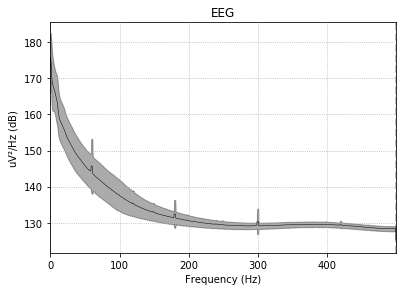

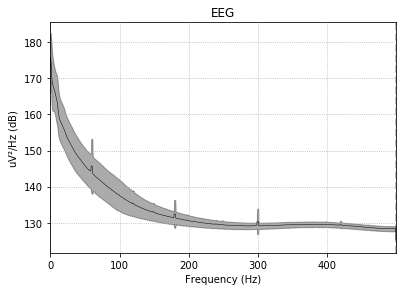

In [30]:
eeg_mne.plot_psd()